# Understanding flow correlations

In this notebook we will work with K401-biotin (protein) to understand the flow correlations of our microtubule network given a velocity field.  The purpose of this analysis is rooted in the study of fluid dynamics and understanding the spatial structures and correlations present in a fluid flow, particularly as captured by Particle Image Velocimetry (PIV) data. Let's break down the motivations and insights gained:

1. **Understanding Flow Correlations**: Fluid flows, especially turbulent ones, have structures or patterns that are correlated over certain spatial scales. By analyzing the spatial correlation of the velocity field, we can gain insights into these structures. The extent over which these correlations exist provides valuable information about the size and nature of the flow structures.

2. **Correlation Length (L)**: The correlation length, often denoted as \( L \), provides a quantifiable metric that characterizes the size of these structures. Specifically, it tells us the average distance over which two velocity vectors in the flow are "similar" or correlated. In many fluid dynamics applications, knowing this length scale can help in understanding the dominant physical processes at play.

3. **Energy Spectrum**: Analyzing the energy spectrum of the flow gives us insights into how energy is distributed across different scales or sizes of flow structures. In turbulence, for instance, energy cascades from large scales to smaller scales, and the shape of the energy spectrum can provide clues about this cascade process.

4. **Comparison with Literature & Validation**: By conducting such analyses and comparing the results with established literature or theoretical predictions, researchers can validate their experimental or simulation data. It helps in ensuring that the observed behaviors align with what's expected or, if not, in identifying new or anomalous behaviors.

5. **Methodological Choices**: The choice between direct spatial correlation and using Fourier methods is often a balance between computational efficiency and direct interpretability. Fourier methods can be more computationally efficient, especially for large datasets, but the direct spatial correlation provides a more intuitive understanding of the flow structures.

In essence, the analyses we conducted help in characterizing the flow, understanding its inherent structures, and ensuring the quality and reliability of the PIV measurements.

### Why correlations? 
Imagine you're observing a group of ants moving food particles across the ground. Even without understanding the complex interactions between individual ants, you might notice some patterns: maybe they tend to move in similar directions in certain areas, or perhaps there are specific zones where they cluster together or avoid. Observing these patterns gives you insights into their collective behavior, even if the individual motivations of each ant remain elusive.

Similarly, in our microtubule-motor network, the individual microtubules and motor proteins are interacting in complex ways to generate movement. While the precise interactions might be intricate and multifaceted, the resulting motion will have patterns – regions where things move coherently in a similar direction or areas of high or low activity.

This is where correlations come in:

1. **Spotting Patterns**: By analyzing how velocities at one point in your sample relate to velocities at another point, you can start to see these patterns. If velocities in two areas are highly correlated, it means they're moving in a synchronized manner. It's like noticing two groups of ants moving in unison, even if they're a bit apart.

2. **Scale of Patterns**: The correlation length, \( L \), provides a quantifiable measure of the "size" of these patterns. If \( L \) is large, it means that even points far apart are moving in a related way, suggesting large-scale coordination in the motion. On the other hand, a small \( L \) indicates more localized interactions.

3. **Understanding Interactions**: Knowing these patterns and scales can give insights into the underlying interactions in your network. For instance, a large-scale coherent motion might suggest long-range interactions or effects, while localized patterns could indicate more short-range, direct interactions between microtubules and motors.

4. **Beyond Averages**: While it's tempting to just look at average speeds or overall flow directions, these can miss the nuances of the system. For instance, even if the average speed is zero (everything seems still), there might be intricate patterns of movement that cancel each other out on average. Correlations help uncover these hidden patterns.

5. **Validation & Quality Check**: Finally, these analyses can serve as a check on the quality and reliability of your PIV measurements. If you see correlations or patterns that are consistent with what you'd expect (based on existing knowledge of microtubule-motor interactions), it gives confidence in your data. Conversely, unexpected patterns might indicate something new and interesting, or potential issues with the measurements.

In essence, while the raw velocities give you a snapshot of what's happening at each point, correlations weave these snapshots together, painting a more comprehensive picture of the collective behavior of your microtubule-motor network.

### If my correlation length is 20 microns, does that mean only two vectors are correlated?

This concept is essentially the two-point correlation function, which gives a measure of how two quantities (in this case, velocities) at two spatial points are correlated as a function of the separation distance between those points. If your correlation length is approximately 20 microns, and each vector in your field is spaced about 20 microns apart, then a few interpretations can be made:

1. **Local Correlation**: The primary correlation in the motion occurs over a distance roughly equivalent to the spacing between vectors. This suggests that the motion at one location is primarily influenced by its immediate neighbor.
  
2. **Beyond Single Vector Correlation**: It's important not to oversimplify by saying "only two vectors are correlated." The correlation length provides a characteristic scale over which velocities are correlated. While the correlation is strongest at short distances (i.e., between immediate neighbors), it doesn't drop to zero immediately beyond that distance. Instead, it decays. So, while the correlation between two vectors 20 microns apart might be strong, there might still be a weaker, but non-negligible, correlation with vectors 40 or 60 microns apart.

3. **Interpreting the Correlation Length**: The correlation length \( L \) can be thought of as the distance over which the correlation drops to a significant fraction (often \( e^{-1} \) or about 37%) of its initial value. So, if \( L \) is 20 microns, it doesn't mean there's no correlation beyond 20 microns, but rather that the correlation has dropped significantly by that point.

In the context of your microtubule-motor network, a correlation length of 20 microns might suggest that interactions or influences in the system have a characteristic length scale of about 20 microns. This could be due to the physical properties of the microtubules, the spacing between them, the range of motor protein interactions, or other factors.

To summarize, while the two-point correlation function provides valuable insights into the spatial coherence of motion in the system, the correlation length should be interpreted as a characteristic scale of this coherence, not as a strict boundary beyond which there's no correlation.

In [1]:
import pandas as pd
import numpy as np
from scipy.signal import correlate2d
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


Let's first load one frame.

In [2]:
def load_and_convert_data(file_path):
    df = pd.read_csv(file_path, sep=',', skiprows=2)
    
    # Convert position and velocity to microns and microns/second
    df['x [um]'] = df['x [m]'] * 1E6
    df['y [um]'] = df['y [m]'] * 1E6
    df['u [um/s]'] = df['u [m/s]'] * 1E6
    df['v [um/s]'] = df['v [m/s]'] * 1E6
    
    # Drop the original columns and retain only the converted ones
    df = df[['x [um]', 'y [um]', 'u [um/s]', 'v [um/s]']]
    
    return df

# Load the data using the updated function
data_0001 = load_and_convert_data("../../data/k401bio-250nM-piv/PIVlab_0001.txt")
data_0001.head()


,x [um],y [um],u [um/s],v [um/s]
0,23.287672,23.287672,NaN,NaN
1,23.287672,45.205481,NaN,NaN
2,23.287672,67.123285,NaN,NaN
3,23.287672,89.041096,NaN,NaN
4,23.287672,110.958907,NaN,NaN


In [3]:
def compute_mean_speed(data):
    """
    Compute the mean speed from the velocity field.
    """
    u = data.pivot(index='y [um]', columns='x [um]', values='u [um/s]').values
    v = data.pivot(index='y [um]', columns='x [um]', values='v [um/s]').values
    
    # Handle NaN values: replacing them with zero
    u[np.isnan(u)] = 0
    v[np.isnan(v)] = 0
    
    # Calculate speed (magnitude of velocity vectors)
    speed = np.sqrt(u**2 + v**2)
    
    # Compute mean speed
    mean_speed = np.mean(speed)
    
    return mean_speed

mean_speed_0001 = compute_mean_speed(data_0001)
mean_speed_0001

1.138905631366823

Let's see what the hell with all this correlation thing. The Pivot function takes the x and y position columns and makes them a grid of velocity values. We can do that for both the u and v component.

In [4]:
u = pd.DataFrame(data_0001.pivot(index='y [um]', columns='x [um]', values='u [um/s]').values)
v = pd.DataFrame(data_0001.pivot(index='y [um]', columns='x [um]', values='v [um/s]').values)
u[np.isnan(u)] = 0
v[np.isnan(v)] = 0
u

,0,1,2,3,4,5,6,7,8,9,...,117,118,119,120,121,122,123,124,125,126
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
124,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


And this is how they look individually:

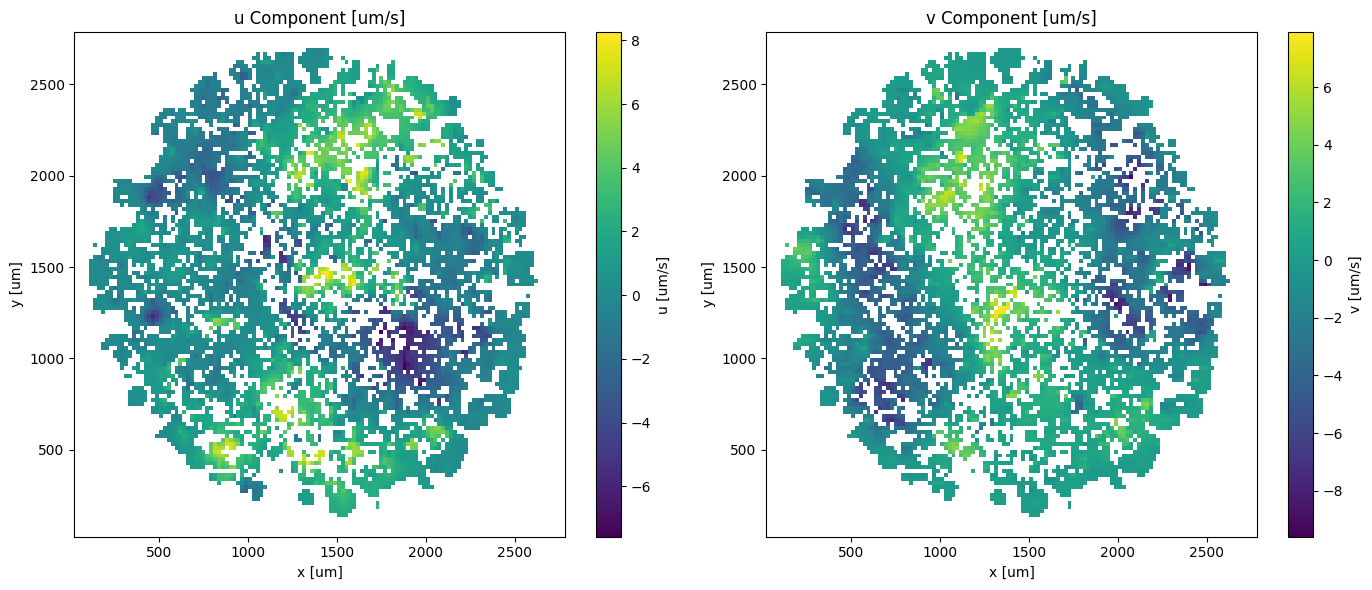

In [5]:
def plot_velocity_components_labeled(data):
    # Reshape the velocity fields into 2D arrays
    u = data.pivot(index='y [um]', columns='x [um]', values='u [um/s]').values
    v = data.pivot(index='y [um]', columns='x [um]', values='v [um/s]').values
    
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    # Define the extent for axis labels
    extent = [data['x [um]'].min(), data['x [um]'].max(), data['y [um]'].min(), data['y [um]'].max()]
    
    # Plot u component
    im1 = ax[0].imshow(u, cmap='viridis', origin='lower', extent=extent, aspect='auto')
    ax[0].set_title("u Component [um/s]")
    ax[0].set_xlabel("x [um]")
    ax[0].set_ylabel("y [um]")
    fig.colorbar(im1, ax=ax[0], label="u [um/s]")
    
    # Plot v component
    im2 = ax[1].imshow(v, cmap='viridis', origin='lower', extent=extent, aspect='auto')
    ax[1].set_title("v Component [um/s]")
    ax[1].set_xlabel("x [um]")
    ax[1].set_ylabel("y [um]")
    fig.colorbar(im2, ax=ax[1], label="v [um/s]")
    
    plt.tight_layout()
    plt.show()

plot_velocity_components_labeled(data_0001)


Now let's talk about the correlate2d function.


1. The dot product of the velocity vector with itself at each point is computed. This gives a 2D array (`uv_dot`) representing the magnitude of the velocity squared.
2. The `correlate2d` function is used to compute the 2D autocorrelation of this `uv_dot` array. Essentially, this function slides the `uv_dot` array over itself and computes the sum of products at each position. The result is a 2D array (`R`) where each value represents the correlation between the `uv_dot` values at different spatial lags.
3. The resulting correlation array `R` is normalized by its center value.

The output matrix `R` represents the 2D autocorrelation of the velocity magnitude squared. The central point of this matrix corresponds to a spatial lag of zero (i.e., comparing the `uv_dot` values with themselves). As you move away from the center in any direction, you're looking at the correlation between `uv_dot` values at increasing spatial lags.

In simple terms:
- If a value in `R` is close to 1, it means the velocity magnitudes (squared) at two points separated by the corresponding spatial lag are highly correlated.
- If a value in `R` is close to 0, it means there's little to no correlation between the velocity magnitudes at that spatial lag.
- Negative values would indicate an inverse correlation.

The interpretation of this matrix can give insights into spatial patterns and structures in the flow, and the scale at which these patterns exist.

In [6]:
def compute_velocity_autocorrelation(data):
    """
    Compute the velocity autocorrelation from the velocity field.
    """
    u = data.pivot(index='y [um]', columns='x [um]', values='u [um/s]').values
    v = data.pivot(index='y [um]', columns='x [um]', values='v [um/s]').values

    # Handle NaN values: replacing them with zero
    u[np.isnan(u)] = 0
    v[np.isnan(v)] = 0

    # Compute dot products of velocity vectors
    uv_dot = u * u + v * v
    
    # Computing the 2D autocorrelation using FFT (through the correlate2d function)
    R = correlate2d(uv_dot, uv_dot, mode='full', boundary='fill', fillvalue=0)
    
    # Normalizing the correlation function
    R /= R[R.shape[0] // 2, R.shape[1] // 2]
    
    return R

R_velocity_0001 = compute_velocity_autocorrelation(data_0001)

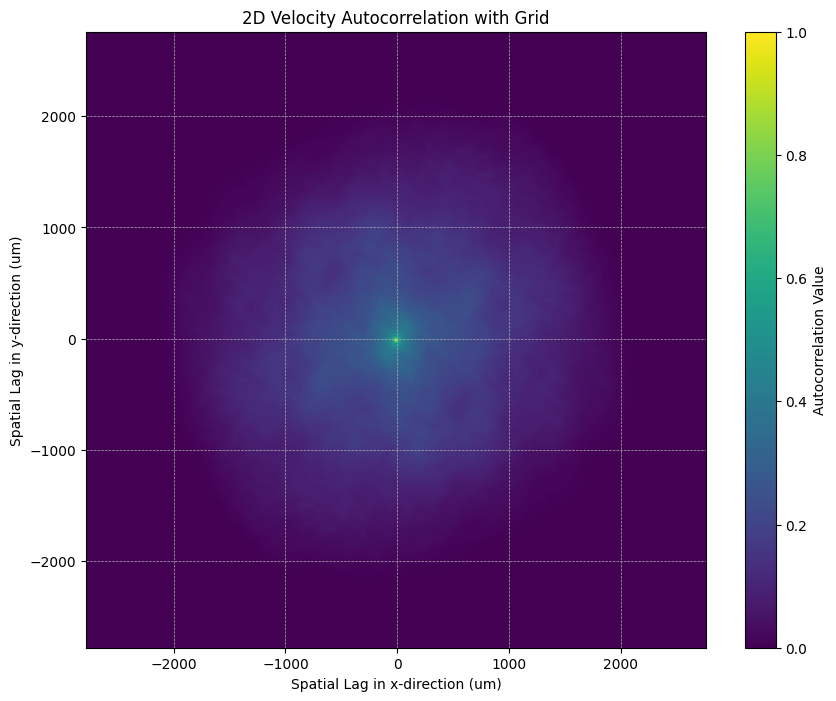

In [7]:
def plot_2D_correlation(data):
    R = compute_velocity_autocorrelation(data)
    
    # Getting the spatial dimensions from the data
    x_values = data['x [um]'].unique()
    y_values = data['y [um]'].unique()
    dx = x_values[1] - x_values[0]
    dy = y_values[1] - y_values[0]
    
    # Extent for the image
    extent = [-R.shape[1]//2*dx, R.shape[1]//2*dx, -R.shape[0]//2*dy, R.shape[0]//2*dy]
    
    plt.figure(figsize=(10, 8))
    plt.imshow(R, cmap='viridis', origin='lower', extent=extent, aspect='auto')
    plt.colorbar(label="Autocorrelation Value")
    plt.title("2D Velocity Autocorrelation with Grid")
    plt.xlabel("Spatial Lag in x-direction (um)")
    plt.ylabel("Spatial Lag in y-direction (um)")
    
    # Displaying the grid
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    plt.show()

plot_2D_correlation(data_0001)


Certainly! Let's break down the math step by step.

### 1. Calculation of \( r \):

For each pixel (or point) \( (x, y) \) in the 2D matrix \( R \), we want to determine its distance from the center of the matrix.

Given:

- \( x_{\text{center}} \): horizontal coordinate of the center of \( R \)
- \( y_{\text{center}} \): vertical coordinate of the center of \( R \)

The distance \( r \) of any point \( (x, y) \) from the center is calculated using the Pythagorean theorem:

\[
r(x, y) = \sqrt{(x - x_{\text{center}})^2 + (y - y_{\text{center}})^2}
\]

This gives us a matrix \( r \), where each element represents the radial distance of the corresponding point in \( R \) from the center.

### 2. Calculation of `radial_mean`:

The goal here is to compute the average value of \( R \) for each unique value of \( r \). 

Let's denote:

- \( R_i \): The values in the matrix \( R \) corresponding to a particular radial distance \( r_i \)
- \( N(r_i) \): The number of points in \( R \) that have a radial distance \( r_i \)

The average value of \( R \) for a particular radial distance \( r_i \) is given by:

\[
\text{radial\_mean}(r_i) = \frac{\sum R_i}{N(r_i)}
\]

Where:
- \( \sum R_i \) is the sum of all values in \( R \) that have a radial distance \( r_i \)

By applying the above formula for all unique values of \( r \), we get the `radial_mean` array, which provides the average value of the 2D autocorrelation matrix \( R \) for each unique radial distance.

### Summary:

The matrix \( r \) captures the radial distance of every point in \( R \) from the center. The `radial_mean` array gives us a radial (or spherically-averaged) profile of the 2D autocorrelation, indicating how the correlation changes as we move radially outward from the center of \( R \).

In [8]:
def extract_radial_velocity_autocorrelation(R):
    """
    Extract the radial correlation from the 2D velocity autocorrelation.
    """
    y, x = np.indices(R.shape)

    # Distance from center to any (x,y)
    r = np.sqrt((x - R.shape[1]//2)**2 + (y - R.shape[0]//2)**2).astype(int)
    
    # 
    radial_mean = np.bincount(r.ravel(), R.ravel()) / np.bincount(r.ravel())
    
    return radial_mean

# Extract radial form of the velocity autocorrelation for both frames
radial_velocity_0001 = extract_radial_velocity_autocorrelation(R_velocity_0001)

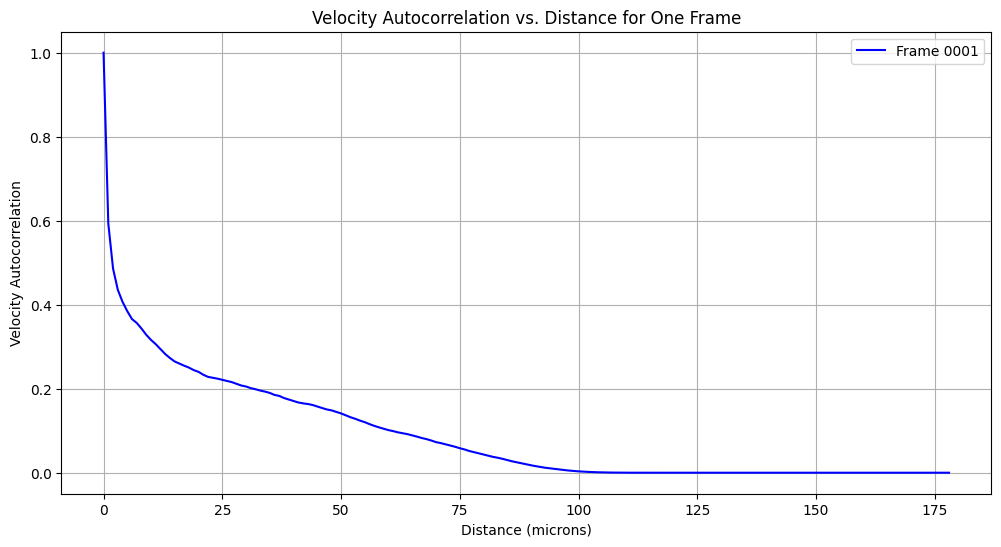

In [9]:
# Plotting Velocity Autocorrelation vs. Distance
distances = np.arange(len(radial_velocity_0001))
plt.figure(figsize=(12,6))
plt.plot(distances, radial_velocity_0001, label="Frame 0001", color="blue")
plt.xlabel("Distance (microns)")
plt.ylabel("Velocity Autocorrelation")
plt.title("Velocity Autocorrelation vs. Distance for One Frame")
plt.legend()
plt.grid(True)
plt.show()


Yes, from the excerpt of the reference paper you provided earlier, there's mention of fitting the velocity autocorrelation, \( A_{\text{vel}}(r,\tau) \), to an exponential function. Specifically, the exponential function is of the form:

\[
A_{\text{vel}}(r,\tau) = Ae^{-\frac{\tau}{B}} + C
\]

This is a typical way to analyze autocorrelation functions in fluid dynamics, especially in turbulence studies. The reason is that in many turbulent flows, the autocorrelation of velocity (or other flow properties) decays exponentially with increasing distance or time lag.

The idea behind fitting to an exponential is to determine the correlation length (or time scale) of the flow. The correlation length, in this context, represents the typical distance over which flow properties (like velocity) remain correlated. Beyond this distance, the properties become increasingly uncorrelated.

From the fit, you can extract parameters:

- \( A \): Amplitude of the correlation.
- \( B \): Correlation length (or time scale). This is essentially the decay constant of the exponential, indicating how quickly the correlation drops off.
- \( C \): Background or baseline correlation (often close to zero if there's no long-range correlation).

The paper further defines the correlation length, \( \lambda(\tau) \), as:

\[
\lambda(\tau) = -B \times \log \left( \frac{0.3-C}{A} \right)
\]

This formula is used to compute the correlation length based on the parameters obtained from the exponential fit.

To apply this to your data:

1. You would fit the radial velocity autocorrelation data to the exponential function.
2. Extract the parameters \( A \), \( B \), and \( C \) from the fit.
3. Use the parameters to calculate the correlation length using the above formula.

Would you like assistance in implementing and applying this exponential fitting to your data?

In [10]:
from scipy.optimize import curve_fit

def exponential_fit(r, A, B, C):
    """
    Exponential function for fitting the autocorrelation.
    """
    return A * np.exp(-r / B) + C

def fit_and_extract_lambda(distances, radial_velocity):
    """
    Fit the radial velocity autocorrelation to the exponential function and extract lambda.
    """
    # Fitting the radial autocorrelation to the exponential function
    popt, _ = curve_fit(exponential_fit, distances, radial_velocity, p0=[1, 100, 0])
    
    # Extracting the correlation length lambda from the fit parameters
    A, B, C = popt
    lambda_val = -B * np.log((0.3 - C) / A)
    
    return lambda_val

# Extracting lambda for the first frame
lambda_0001 = fit_and_extract_lambda(distances, radial_velocity_0001)
lambda_0001


17.414393424342414

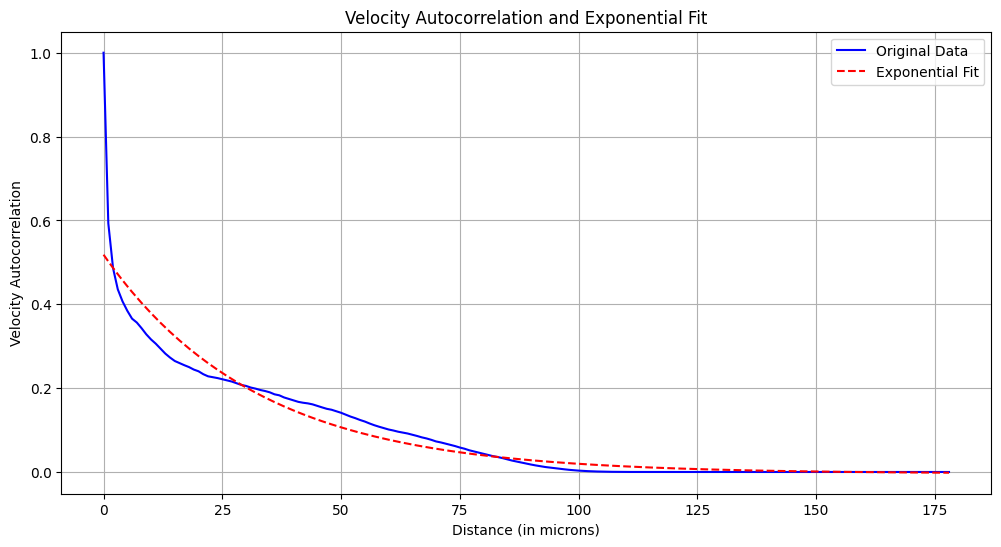

In [11]:
def plot_exponential_fit(distances, radial_velocity):
    """
    Fit the radial velocity autocorrelation to the exponential function and plot the fit along with the original data.
    """
    # Fitting the radial autocorrelation to the exponential function
    popt, _ = curve_fit(exponential_fit, distances, radial_velocity, p0=[1, 100, 0])
    
    # Generating the exponential curve using the fitted parameters
    fitted_curve = exponential_fit(distances, *popt)
    
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(distances, radial_velocity, 'b-', label="Original Data")
    plt.plot(distances, fitted_curve, 'r--', label="Exponential Fit")
    plt.xlabel("Distance (in microns)")
    plt.ylabel("Velocity Autocorrelation")
    plt.title("Velocity Autocorrelation and Exponential Fit")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plotting the exponential fit for the radial_velocity_0001 data
plot_exponential_fit(distances, radial_velocity_0001)


### Fourier Analysis:

Analyzing data in the Fourier domain can provide insights into the frequency or wavenumber components present in the data. For the PIV data, this can translate to understanding the dominant scales of motion or structures in the flow.

The 2D autocorrelation function in the spatial domain is related to the power spectral density in the Fourier domain. When you take the Fourier transform of the autocorrelation, you get the power spectral density, which tells you how the variance (or power) of the velocity field is distributed over different scales (frequencies).

The extraction of the radial average of the 2D autocorrelation is analogous to looking at how the power (or energy) in the Fourier domain is distributed radially. In other words, it's like looking at how much energy is contained at different scales, without caring about the direction of those scales.

To summarize, the radial average of the 2D autocorrelation provides a simplified, direction-agnostic view of the spatial correlations in the data. Fourier analysis, on the other hand, provides insights into the frequency content of the data, which can be linked to scales of structures in the flow. Both are useful, but they offer different perspectives on the data.

Here's a step-by-step breakdown of what we can do with the Fourier Transform:

1. **Compute the Fourier Transform**: Convert the spatial data (like the velocity fields) to the frequency (or wavenumber) domain using the Fourier Transform. This gives us the spatial frequency components of the velocity field.
  
2. **Compute Power Spectrum**: The magnitude of the Fourier Transform squared gives the power spectral density, which tells us how the variance (or power) of the velocity fields is distributed across different spatial frequencies.
  
3. **Visualize**: By plotting the power spectrum, we can identify dominant spatial scales in the flow. Peaks in the power spectrum represent spatial scales (or structures) that are prevalent in the flow.
  
4. **Inverse Fourier Transform**: If needed, we can filter or modify the data in the Fourier domain and then convert it back to the spatial domain using the inverse Fourier Transform.

Let's start by computing the Fourier Transform of the velocity fields and then visualizing the power spectrum. 

In [13]:
def compute_autocorrelation(data):
    """
    Compute the spatial autocorrelation of the velocity field using 2D correlation.
    """
    # Extracting the velocities
    u = data.pivot(index='y [um]', columns='x [um]', values='u [um/s]').values
    v = data.pivot(index='y [um]', columns='x [um]', values='v [um/s]').values

    # Handle NaN values: replacing them with zero for the correlation calculation
    u[np.isnan(u)] = 0
    v[np.isnan(v)] = 0

    # Normalizing the velocities
    u_norm = u - np.mean(u)
    v_norm = v - np.mean(v)
    
    # Computing the 2D autocorrelation using FFT (through the correlate2d function)
    Ru = correlate2d(u_norm, u_norm, mode='full', boundary='fill', fillvalue=0)
    Rv = correlate2d(v_norm, v_norm, mode='full', boundary='fill', fillvalue=0)

    # Normalizing the autocorrelation function
    Ru /= Ru[Ru.shape[0] // 2, Ru.shape[1] // 2]
    Rv /= Rv[Rv.shape[0] // 2, Rv.shape[1] // 2]

    return Ru, Rv

In [14]:
def compute_energy_spectrum(Ru, Rv):
    """
    Compute the energy spectrum from the spatial autocorrelation using the Fourier Transform.
    """
    # Compute the 2D Fourier transform of the autocorrelation functions
    Fu = np.fft.fftshift(np.fft.fft2(Ru))
    Fv = np.fft.fftshift(np.fft.fft2(Rv))
    
    # Compute the radial energy spectrum (averaging over circular shells in k-space)
    kx = np.fft.fftshift(np.fft.fftfreq(Ru.shape[0]))
    ky = np.fft.fftshift(np.fft.fftfreq(Ru.shape[1]))
    kx, ky = np.meshgrid(kx, ky)
    k = np.sqrt(kx**2 + ky**2)
    
    # Define the bins for k (radial wavenumbers)
    k_bins = np.linspace(0, 0.5, Ru.shape[0]//2)
    k_bin_centers = 0.5 * (k_bins[:-1] + k_bins[1:])
    
    # Compute the binned energy spectrum
    E_u = np.histogram(k.ravel(), bins=k_bins, weights=(np.abs(Fu)**2).ravel())[0]
    E_v = np.histogram(k.ravel(), bins=k_bins, weights=(np.abs(Fv)**2).ravel())[0]
    
    return k_bin_centers, E_u, E_v

In [15]:
def exponential_decay(r, L):
    """
    Exponential decay function for fitting.
    """
    return np.exp(-r/L)

def compute_correlation_length(Ru):
    """
    Compute the correlation length by fitting the autocorrelation function to an exponential decay.
    """
    # Extract the 1D radial autocorrelation from the 2D autocorrelation
    y, x = np.indices(Ru.shape)
    r = np.sqrt((x - Ru.shape[1]//2)**2 + (y - Ru.shape[0]//2)**2).astype(np.int64)
    radial_mean = np.bincount(r.ravel(), Ru.ravel()) / np.bincount(r.ravel())
    
    # Fit the radial autocorrelation to the exponential decay function
    r_values = np.arange(len(radial_mean))
    popt, _ = curve_fit(exponential_decay, r_values, radial_mean, p0=[100])
    
    return popt[0]

def extract_radial_velocity_product_correlation(R):
    """
    Extract the radial autocorrelation from the 2D autocorrelation.
    """
    y, x = np.indices(R.shape)
    r = np.sqrt((x - R.shape[1]//2)**2 + (y - R.shape[0]//2)**2).astype(int)
    radial_mean = np.bincount(r.ravel(), R.ravel()) / np.bincount(r.ravel())
    
    return radial_mean



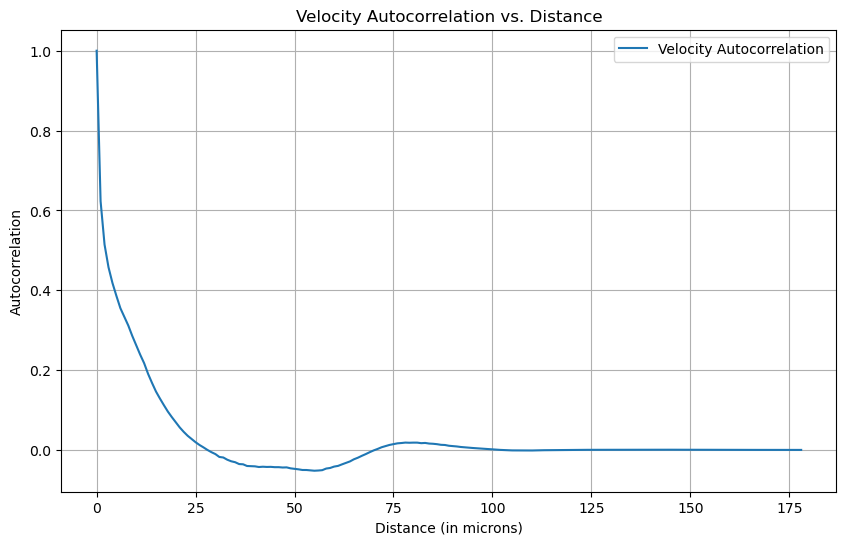

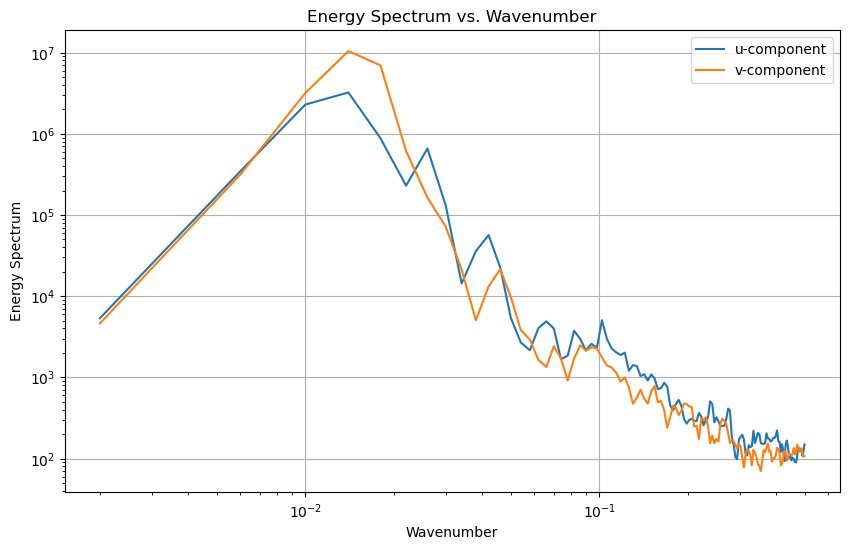

The computed correlation length L is: 6.07 microns


In [17]:
Ru, Rv = compute_autocorrelation(data_0001)
k, E_u_avg, E_v_avg = compute_energy_spectrum(Ru, Rv)
L = compute_correlation_length(Ru)
radial_autocorr = extract_radial_velocity_product_correlation(Ru)

# Plotting Velocity Autocorrelation vs. Distance
distances = np.arange(len(radial_autocorr))
plt.figure(figsize=(10,6))
plt.plot(distances, radial_autocorr, label="Velocity Autocorrelation")
plt.xlabel("Distance (in microns)")
plt.ylabel("Autocorrelation")
plt.title("Velocity Autocorrelation vs. Distance")
plt.legend()
plt.grid(True)
plt.show()

# Plotting Energy Spectrum vs. Wavenumber
plt.figure(figsize=(10,6))
plt.loglog(k, E_u_avg, label="u-component")
plt.loglog(k, E_v_avg, label="v-component")
plt.xlabel("Wavenumber")
plt.ylabel("Energy Spectrum")
plt.title("Energy Spectrum vs. Wavenumber")
plt.legend()
plt.grid(True)
plt.show()

# Displaying the correlation length L
print(f"The computed correlation length L is: {L:.2f} microns")


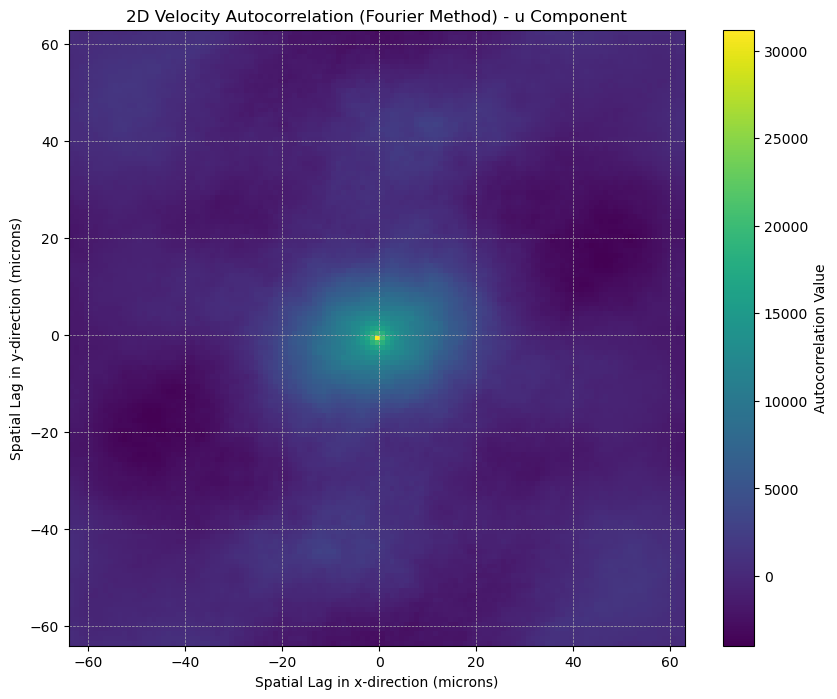

In [18]:
def compute_velocity_autocorrelation_fourier(data):
    """
    Compute the spatial autocorrelation of the velocity field using Fourier transforms.
    """
    # Extracting the velocities
    u = data.pivot(index='y [um]', columns='x [um]', values='u [um/s]').values
    v = data.pivot(index='y [um]', columns='x [um]', values='v [um/s]').values

    # Handle NaN values: replacing them with zero
    u[np.isnan(u)] = 0
    v[np.isnan(v)] = 0

    # Normalizing the velocities
    u_norm = u - np.mean(u)
    v_norm = v - np.mean(v)

    # Fourier transform of the normalized velocities
    F_u_norm = np.fft.fft2(u_norm)
    F_v_norm = np.fft.fft2(v_norm)
    
    # Power spectrum
    power_spectrum_u = np.abs(F_u_norm)**2
    power_spectrum_v = np.abs(F_v_norm)**2
    
    # Inverse Fourier transform of the power spectrum gives the autocorrelation
    R_u = np.fft.ifft2(power_spectrum_u).real
    R_v = np.fft.ifft2(power_spectrum_v).real
    
    # Shift the result to have zero at the center
    R_u = np.fft.fftshift(R_u)
    R_v = np.fft.fftshift(R_v)
    
    return R_u, R_v

# Compute the 2D velocity autocorrelation using Fourier method
R_u_fourier, R_v_fourier = compute_velocity_autocorrelation_fourier(data_0001)

# Visualization
plt.figure(figsize=(10, 8))
plt.imshow(R_u_fourier, cmap='viridis', origin='lower', extent=[-R_u_fourier.shape[1]//2, R_u_fourier.shape[1]//2, -R_u_fourier.shape[0]//2, R_u_fourier.shape[0]//2])
plt.colorbar(label="Autocorrelation Value")
plt.title("2D Velocity Autocorrelation (Fourier Method) - u Component")
plt.xlabel("Spatial Lag in x-direction (microns)")
plt.ylabel("Spatial Lag in y-direction (microns)")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


In [19]:
# Extract the radial autocorrelation
radial_autocorr_fourier = extract_radial_velocity_product_correlation(R_u_fourier)

# Adjusting the distances array to match the size of the radial_autocorr_fourier
distances_fourier = np.arange(len(radial_autocorr_fourier))

# Fit the radial autocorrelation to the exponential function to extract the correlation length
correlation_length_fourier = fit_and_extract_lambda(distances_fourier, radial_autocorr_fourier)

correlation_length_fourier

60.432381602026844

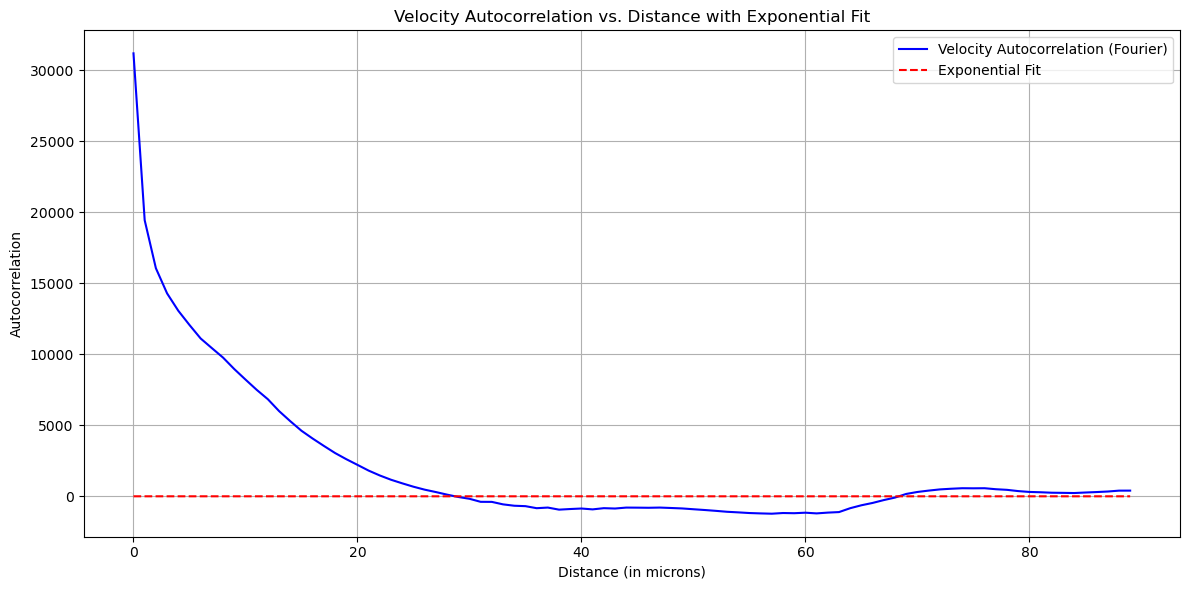

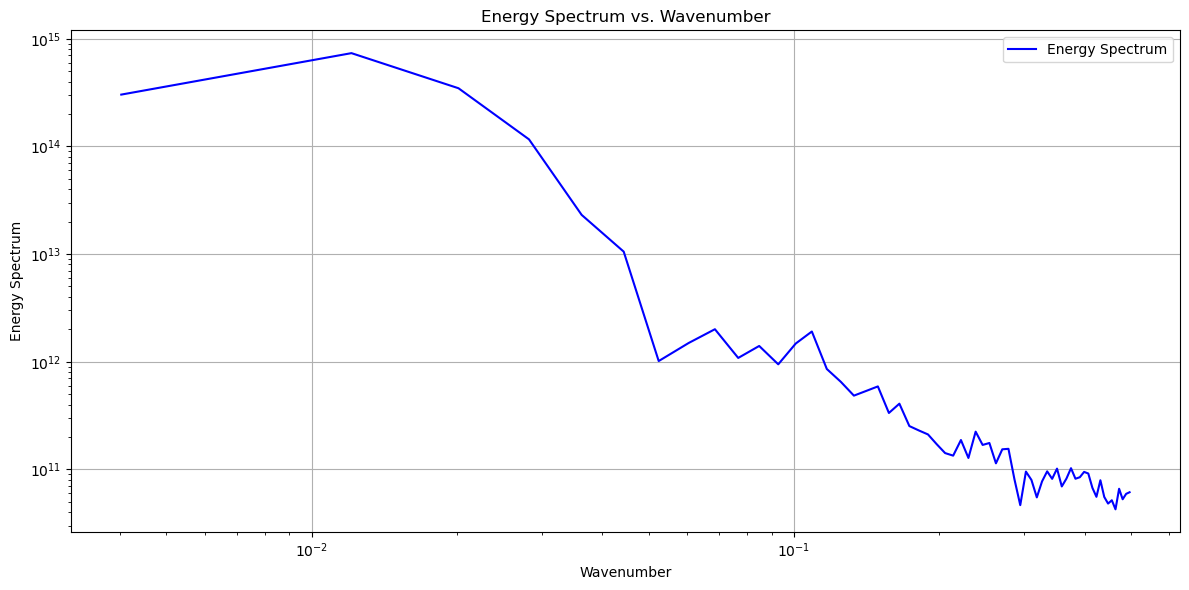

In [20]:
# Computing the energy spectrum
def compute_energy_spectrum_from_autocorrelation(R):
    """
    Compute the energy spectrum from the spatial autocorrelation using the Fourier Transform.
    """
    # Compute the 2D Fourier transform of the autocorrelation function
    F_R = np.fft.fftshift(np.fft.fft2(R))
    
    # Compute the radial energy spectrum (averaging over circular shells in k-space)
    kx = np.fft.fftshift(np.fft.fftfreq(R.shape[0]))
    ky = np.fft.fftshift(np.fft.fftfreq(R.shape[1]))
    kx, ky = np.meshgrid(kx, ky)
    k = np.sqrt(kx**2 + ky**2)
    
    # Define the bins for k (radial wavenumbers)
    k_bins = np.linspace(0, 0.5, R.shape[0]//2)
    k_bin_centers = 0.5 * (k_bins[:-1] + k_bins[1:])
    
    # Compute the binned energy spectrum
    E = np.histogram(k.ravel(), bins=k_bins, weights=(np.abs(F_R)**2).ravel())[0]
    
    return k_bin_centers, E

k_fourier, E_fourier = compute_energy_spectrum_from_autocorrelation(R_u_fourier)

# Plotting Velocity Autocorrelation vs. Distance with Exponential Fit
plt.figure(figsize=(12,6))
plt.plot(distances_fourier, radial_autocorr_fourier, label="Velocity Autocorrelation (Fourier)", color="blue")
plt.plot(distances_fourier, exponential_decay(distances_fourier, correlation_length_fourier), '--', label="Exponential Fit", color="red")
plt.xlabel("Distance (in microns)")
plt.ylabel("Autocorrelation")
plt.title("Velocity Autocorrelation vs. Distance with Exponential Fit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting Energy Spectrum vs. Wavenumber
plt.figure(figsize=(12,6))
plt.loglog(k_fourier, E_fourier, label="Energy Spectrum", color="blue")
plt.xlabel("Wavenumber")
plt.ylabel("Energy Spectrum")
plt.title("Energy Spectrum vs. Wavenumber")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
